<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4

## Help Yelp

---

In this project you will be investigating a small version of the [Yelp challenge dataset](https://www.yelp.com/dataset_challenge). You'll practice using classification algorithms, cross-validation, gridsearching – all that good stuff.



---

### The data

There are 5 individual .csv files that have the information, zipped into .7z format like with the SF data last project. The dataset is located in your datasets folder:

    DSI-SF-2/datasets/yelp_arizona_data.7z

The columns in each are:

    businesses_small_parsed.csv
        business_id: unique business identifier
        name: name of the business
        review_count: number of reviews per business
        city: city business resides in
        stars: average rating
        categories: categories the business falls into (can be one or multiple)
        latitude
        longitude
        neighborhoods: neighborhoods business belongs to
        variable: "property" of the business (a tag)
        value: True/False for the property
        
    reviews_small_nlp_parsed.csv
        user_id: unique user identifier
        review_id: unique review identifier
        votes.cool: how many thought the review was "cool"
        business_id: unique business id the review is for
        votes.funny: how many thought the review was funny
        stars: rating given
        date: date of review
        votes.useful: how many thought the review was useful
        ... 100 columns of counts of most common 2 word phrases that appear in reviews in this review
        
    users_small_parsed.csv
        yelping_since: signup date
        compliments.plain: # of compliments "plain"
        review_count: # of reviews:
        compliments.cute: total # of compliments "cute"
        compliments.writer: # of compliments "writer"
        compliments.note: # of compliments "note" (not sure what this is)
        compliments.hot: # of compliments "hot" (?)
        compliments.cool: # of compliments "cool"
        compliments.profile: # of compliments "profile"
        average_stars: average rating
        compliments.more: # of compliments "more"
        elite: years considered "elite"
        name: user's name
        user_id: unique user id
        votes.cool: # of votes "cool"
        compliments.list: # of compliments "list"
        votes.funny: # of compliments "funny"
        compliments.photos: # of compliments "photos"
        compliments.funny: # of compliments "funny"
        votes.useful: # of votes "useful"
       
    checkins_small_parsed.csv
        business_id: unique business identifier
        variable: day-time identifier of checkins (0-0 is Sunday 0:00 - 1:00am,  for example)
        value: # of checkins at that time
    
    tips_small_nlp_parsed.csv
        user_id: unique user identifier
        business_id: unique business identifier
        likes: likes that the tip has
        date: date of tip
        ... 100 columns of counts of most common 2 word phrases that appear in tips in this tip

The reviews and tips datasets in particular have parsed "NLP" columns with counts of 2-word phrases in that review or tip (a "tip", it seems, is some kind of smaller review).

The user dataset has a lot of columns of counts of different compliments and votes. I'm not sure whether the compliments or votes are _by_ the user or _for_ the user.

---

If you look at the website, or the full data, you'll see I have removed pieces of the data and cut it down quite a bit. This is to simplify it for this project. Specifically, business are limited to be in these cities:

    Phoenix
    Surprise
    Las Vegas
    Waterloo

Apparently there is a city called "Surprise" in Arizona. 

Businesses are also restricted to at least be in one of the following categories, because I thought the mix of them was funny:

    Airports
    Breakfast & Brunch
    Bubble Tea
    Burgers
    Bars
    Bakeries
    Breweries
    Cafes
    Candy Stores
    Comedy Clubs
    Courthouses
    Dance Clubs
    Fast Food
    Museums
    Tattoo
    Vape Shops
    Yoga
    
---

### Project requirements

**You will be performing 4 different sections of analysis, like in the last project.**

Remember that classification targets are categorical and regression targets are continuous variables.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import patsy
import imp

plt.style.use('fivethirtyeight')

from sklearn import grid_search, datasets
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.cross_validation import cross_val_score, cross_val_predict, train_test_split, StratifiedKFold
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression as lm, LogisticRegression as lr, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from ipywidgets import *
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

business = pd.read_csv('/Users/nichollejames/Desktop/DSI-SF-2-oboechick/projects/project-05/yelp_arizona_data/businesses_small_parsed.csv')
# checkins = pd.read_csv('/Users/nichollejames/Desktop/DSI-SF-2-oboechick/projects/project-05/yelp_arizona_data/checkins_small_parsed.csv')
# review = pd.read_csv('/Users/nichollejames/Desktop/DSI-SF-2-oboechick/projects/project-05/yelp_arizona_data/reviews_small_nlp_parsed.csv')
# tips = pd.read_csv('/Users/nichollejames/Desktop/DSI-SF-2-oboechick/projects/project-05/yelp_arizona_data/tips_small_nlp_parsed.csv')
# users = pd.read_csv('/Users/nichollejames/Desktop/DSI-SF-2-oboechick/projects/project-05/yelp_arizona_data/users_small_parsed.csv')


In [2]:
business.head(1)

,business_id,name,review_count,city,stars,categories,latitude,longitude,neighborhoods,variable,value
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"['American (New)', 'Nightlife', 'Dance Clubs',...",33.448399,-112.071702,[],attributes.Ambience.divey,False


In [3]:
business.columns.tolist()

['business_id',
 'name',
 'review_count',
 'city',
 'stars',
 'categories',
 'latitude',
 'longitude',
 'neighborhoods',
 'variable',
 'value']

In [4]:
business.shape

(152832, 11)

In [5]:
business.city.value_counts()

Las Vegas    93818
Phoenix      53279
Surprise      2974
Waterloo      2761
Name: city, dtype: int64

In [6]:
business['city_binary'] = business.city
business['city_binary'] = business['city_binary'].map({ "Las Vegas" : 1, "Phoenix" : 0, "Surprise" : 0, "Waterloo" : 0})

In [7]:
business.city_binary.unique()

array([0, 1])

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Constructing a "profile" for Las Vegas

---

Yelp is interested in building out what they are calling "profiles" for cities. They want you to start with just Las Vegas to see what a prototype of this would look like. Essentially, they want to know what makes Las Vegas distinct from the other four.

Use the data you have to predict Las Vegas from the other variables you have. You should not be predicting the city from any kind of location data or other data perfectly associated with that city (or another city).

You may use any classification algorithm you deem appropriate, or even multiple models. You should:

1. Build at least one model predicting Las Vegas vs. the other cities.
- Validate your model(s).
- Interpret and visualize, in some way, the results.
- Write up a "profile" for Las Vegas. This should be a writeup converting your findings from the model(s) into a human-readable description of the city.

In [10]:
business.corr()

,review_count,stars,latitude,longitude,city_binary
review_count,1.000000,0.153375,0.030362,-0.075295,0.096229
stars,0.153375,1.000000,0.008784,0.007272,0.004952
latitude,0.030362,0.008784,1.000000,0.391506,0.622239
longitude,-0.075295,0.007272,0.391506,1.000000,-0.475385
city_binary,0.096229,0.004952,0.622239,-0.475385,1.000000


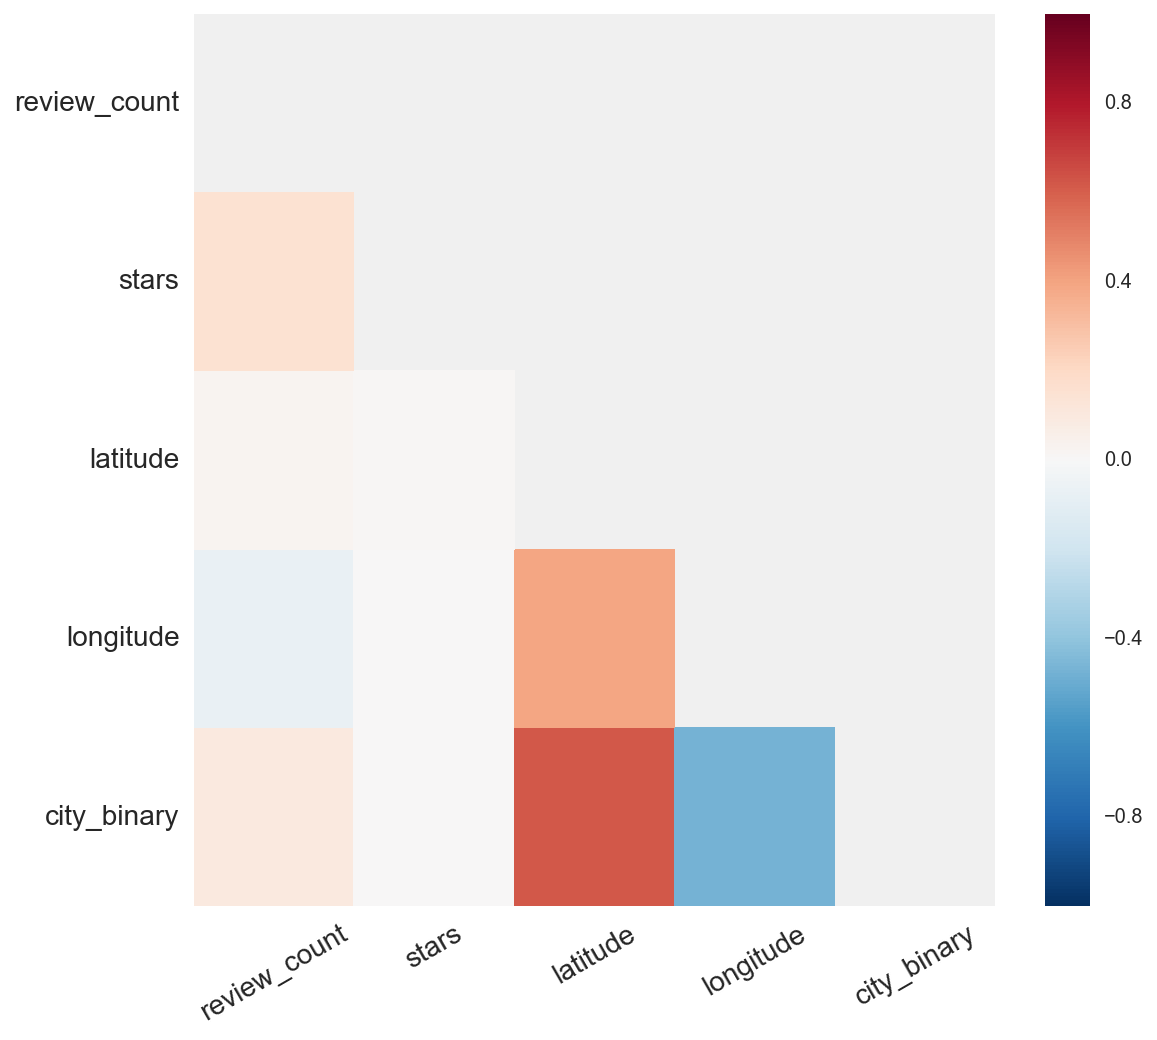

In [33]:
corrs = business.corr()

fig, ax = plt.subplots(figsize=(8,8))

mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corrs, mask=mask)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

plt.show()

In [34]:
formula = "city_binary ~ review_count + stars -1"
y, X = patsy.dmatrices(formula, data=business, return_type = "dataframe")

In [35]:
y = np.ravel(y)
print type(y), y.shape

<type 'numpy.ndarray'> (152832,)


In [36]:
X = X.values

In [37]:
print type(X), X.shape

<type 'numpy.ndarray'> (152832, 2)


In [38]:
logreg = lr()
logreg.fit(X,y)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [39]:
# straight-up R2:
logreg.score(X, y)
# not terrible 

0.61386358877721947

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
print X_train.shape, X_test.shape
print y_train.shape, y_test.shape

(106982, 2) (45850, 2)
(106982,) (45850,)


In [41]:
# train/test split holdout R2:
logreg.fit(X_train, y_train)
holdoutr2 = logreg.score(X_test, y_test)
print holdoutr2
# not much different

0.614591057797


In [42]:
y_pred = model.predict(X_test)
y_pred

NameError: name 'model' is not defined

In [43]:
# This is the confusion matrix

from sklearn.metrics import classification_report

cls_rep = classification_report(y_test, y_pred)
print cls_rep 

NameError: name 'y_pred' is not defined

In [44]:
# next step gridsearch with log reg

y, X = patsy.dmatrices("city_binary ~ review_count + stars -1", data=business, return_type = "dataframe")

In [45]:
# Setup our GridSearch Parmaters
search_parameters = {
    'fit_intercept':  [True, False], 
    'normalize':      [False, True]
}


In [46]:
# Intialize a blank model object

lr = lr()


In [47]:
# Initialize gridsearch

estimator = grid_search.GridSearchCV(lr, search_parameters, cv=5)


In [84]:
# Fit some data!
results = estimator.fit(X, y)

ValueError: Invalid parameter normalize for estimator LogisticRegression. Check the list of available parameters with `estimator.get_params().keys()`.

In [86]:
results.grid_scores_

NameError: name 'results' is not defined

In [85]:
print "Best Score:"
print results.best_score_

Best Score:


NameError: name 'results' is not defined

In [ ]:
print "Best Params:"
print results.best_params_

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Different categories of ratings

---

Yelp is finally ready to admit that their rating system sucks. No one cares about the ratings, they just use the site to find out what's nearby. The ratings are simply too unreliable for people. 

Yelp hypothesizes that this is, in fact, because different people tend to give their ratings based on different things. They believe that perhaps some people always base their ratings on quality of food, others on service, and perhaps other categories as well. 

1. Do some users tend to talk about service more than others in reviews/tips? Divide up the tips/reviews into more "service-focused" ones and those less concerned with service.
2. Create two new ratings for businesses: ratings from just the service-focused reviews and ratings from the non-service reviews.
3. Construct a regression model for each of the two ratings. They should use the same predictor variables (of your choice). 
4. Validate the performance of the models.
5. Do the models coefficients differ at all? What does this tell you about the hypothesis that there are in fact two different kinds of ratings?

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Identifying "elite" users

---

Yelp, though having their own formula for determining whether a user is elite or not, is interested in delving deeper into what differentiates an elite user from a normal user at a broader level.

Use a classification model to predict whether a user is elite or not. Note that users can be elite in some years and not in others.

1. What things predict well whether a user is elite or not?
- Validate the model.
- If you were to remove the "counts" metrics for users (reviews, votes, compliments), what distinguishes an elite user, if anything? Validate the model and compare it to the one with the count variables.
- Think of a way to visually represent your results in a compelling way.
- Give a brief write-up of your findings.


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Find something interesting on your own

---

You want to impress your superiors at Yelp by doing some investigation into the data on your own. You want to do classification, but you're not sure on what.

1. Create a hypothesis or hypotheses about the data based on whatever you are interested in, as long as it is predicting a category of some kind (classification).
2. Explore the data visually (ideally related to this hypothesis).
3. Build one or more classification models to predict your target variable. **Your modeling should include gridsearching to find optimal model parameters.**
4. Evaluate the performance of your model. Explain why your model may have chosen those specific parameters during the gridsearch process.
5. Write up what the model tells you. Does it validate or invalidate your hypothesis? Write this up as if for a non-technical audience.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. ROC and Precision-recall

---

Some categories have fewer overall businesses than others. Choose two categories of businesses to predict, one that makes your proportion of target classes as even as possible, and another that has very few businesses and thus makes the target varible imbalanced.

1. Create two classification models predicting these categories. Optimize the models and choose variables as you see fit.
- Make confusion matrices for your models. Describe the confusion matrices and explain what they tell you about your models' performance.
- Make ROC curves for both models. What do the ROC curves describe and what do they tell you about your model?
- Make Precision-Recall curves for the models. What do they describe? How do they compare to the ROC curves?
- Explain when Precision-Recall may be preferable to ROC. Is that the case in either of your models?